## Regularisation in NNs¶

Before we start doing anything, I think it's important to understand for NLP, this is the intuitive process on what we are trying to do when we are processing our data in the IMDB dataset:
1. Tokenization: break sentence into individual words
    - Before: `"PyTorch seems really easy to use!"`
    - After: `["PyTorch", "seems", "really", "easy", "to", "use", "!"]`
2. Building vocabulary: build an index of words associated with unique numbers
    - Before: `["PyTorch", "seems", "really", "easy", "to", "use", "!"]`
    - After: `{"Pytorch: 0, "seems": 1, "really": 2, ...}`
3. Convert to numerals: map words to unique numbers (indices)
    - Before: `{"Pytorch: 0, "seems": 1, "really": 2, ...}`
    - After: `[0, 1, 2, ...]`
4. Embedding look-up: map sentences (indices now) to fixed matrices
    - ```[[0.1, 0.4, 0.3],
       [0.8, 0.1, 0.5],
       ...]```

In [1]:
# Critical plotting imports
import matplotlib.pyplot as plt
%matplotlib inline

# Checnking for module version 
from cmp_version import cmp_version 

# PyTorch imports
from torchtext import __version__ as ttver
# https://github.com/pytorch/text/releases/tag/v0.9.0-rc5
if cmp_version(ttver,"0.9.0")>=0: 
    from torchtext.legacy import data, datasets
else:
    from torchtext import data, datasets
import torch
import torch.nn as nn
import torch.nn.functional as F

# Checking for iterable objects
import collections
import random

In [2]:
# Set seed
torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(1337)

In [3]:
# Set plotting style
plt.style.use(('dark_background', 'bmh'))
plt.rc('axes', facecolor='none')
plt.rc('figure', figsize=(16, 4))

In [4]:
# Create instances of fields
# The important field here is fix_length: all examples using this field will be padded to, or None for flexible sequence lengths
# We are fixing this because we will be using a FNN not an LSTM/RNN/GRU where we can go through uneven sequence lengths
max_len = 80
text = data.Field(sequential=True, fix_length=max_len, batch_first=True, lower=True, dtype=torch.long)
label = data.LabelField(sequential=False, dtype=torch.float)

In [5]:
# Calling splits() class method of datasets.IMDB to return a torchtext.data.Dataset object
#datasets.IMDB.download('./')
ds_train, ds_test = datasets.IMDB.splits(text, label, path='./imdb/aclImdb/')

In [6]:
# Training and test set each 25k samples
# 2 fields due to the way we split above
print('train : ', len(ds_train))
print('test : ', len(ds_test))
print('train.fields :', ds_train.fields)

train :  25000
test :  25000
train.fields : {'text': <torchtext.legacy.data.field.Field object at 0x12b3e8b70>, 'label': <torchtext.legacy.data.field.LabelField object at 0x12b3e8a58>}


In [7]:
# Get validation set
seed_num = 1337
ds_train, ds_valid = ds_train.split(random_state=random.seed(seed_num))

In [8]:
# Now we've training, validation and test set
print('train : ', len(ds_train))
print('valid : ', len(ds_valid))
print('test  : ', len(ds_test))

train :  17500
valid :  7500
test  :  25000


In [9]:
# Build vocabulary
# num_words = 25000
num_words = 1000
text.build_vocab(ds_train, max_size=num_words)
label.build_vocab(ds_train)

In [10]:
# Print vocab size
print('Vocabulary size: {}'.format(len(text.vocab)))
print('Label size: {}'.format(len(label.vocab)))

Vocabulary size: 1002
Label size: 2


In [11]:
# Print most common vocabulary text
most_common_samples = 10
print(text.vocab.freqs.most_common(most_common_samples))

[('the', 225411), ('a', 111661), ('and', 110736), ('of', 101281), ('to', 93618), ('is', 73247), ('in', 63011), ('i', 49141), ('this', 49010), ('that', 46426)]


In [12]:
# Print most common labels
print(label.vocab.freqs.most_common())

[('neg', 8835), ('pos', 8665)]


In [13]:
# Sample 0 label
ds_train[0].label

'neg'

In [ ]:
# Sample 0 text: broken down into individual portions
ds_train[0].text

In [15]:
# Sample 0 text: human readeable sample
def show_text(sample):
    print(' '.join(word for word in sample))
    
show_text(ds_train[0].text)

just about everything in this movie is wrong, wrong, wrong. take mike myers, for example. he's reached the point where you realize that his shtick hasn't changed since his snl days, over ten years ago. he's doing the same cutesy stream-of-consciousness jokes and the same voices. his cat is painfully unfunny. he tries way to hard. he's some weird type a comedian, not the cool cat he's supposed to be. the rest of the movie is just as bad. the sets are unbelievably ugly --- and clearly a waste of millions of dollars. (cardboard cut-outs for the background buildings would have made more sense than constructing an entire neighborhood and main street.) alec balwin tries to do a funny great santini impression, but he ends up looking and sounding incoherent. there's even an innapropriate cheesecake moment with faux celebrity paris hilton --- that sticks in the mind simply because this is supposed to be a dr. seuss story. avoid this movie at all costs, folks. it's not even an interesting train 

In [16]:
# Create and iterable object for our training, validation and testing datasets
# Batches examples of similar lengths together that minimizes amount of padding needed
batch_size = 64  # Change batch size from 1 to bigger number once explanation is done
train_loader, valid_loader, test_loader = data.BucketIterator.splits(
    (ds_train, ds_valid, ds_test), batch_size=batch_size, sort_key=lambda x: len(x.text), repeat=False
)

In [17]:
# Check if iterator above is an iterable which should show True
isinstance(train_loader, collections.Iterable)

True

In [18]:
# What's inside this iteratable object? Our text and label although now everything is in machine format (not "words") but in numbers!
# The text we saw above becomes a matrix of size 1 x 80 represented by the fixed length we defined before that
list(train_loader)[0]


[torchtext.legacy.data.batch.Batch of size 64]
	[.text]:[torch.LongTensor of size 64x80]
	[.label]:[torch.FloatTensor of size 64]

In [19]:
# Alternative to above, this is much faster but the above code is easy to understand and implement
next(train_loader.__iter__())


[torchtext.legacy.data.batch.Batch of size 64]
	[.text]:[torch.LongTensor of size 64x80]
	[.label]:[torch.FloatTensor of size 64]

In [20]:
test_batch = next(train_loader.__iter__())

In [21]:
# What methods can we call on this batch object? Text and label
test_batch.fields

dict_keys(['text', 'label'])

In [22]:
# Let's break this down to check what's in a batch
test_batch.text

tensor([[190,  10, 180,  ...,   2,  24,   7],
        [  9, 178, 206,  ...,  97,   0,  29],
        [ 52,   7,   3,  ...,  48,   0,  21],
        ...,
        [  0,   0,   4,  ...,   2,   0,   0],
        [  2,   0, 654,  ...,   0,   0, 148],
        [  9, 201,  10,  ...,  22,   0, 550]])

In [23]:
# 1 comment per batch, each comment is limited to a size of 80 as we've defined
test_batch.text.size()

torch.Size([64, 80])

In [24]:
test_batch.label

tensor([1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
        1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        1., 1., 0., 0., 0., 1., 0., 1., 0., 1.])

In [25]:
# Extremely weird problem in torchtext where BucketIterator returns a Batch object versus just a simple tuple of tensors containing our text index and labels
# So let's fix this with a new class FixBatchGenerator

class FixBatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)
            
train_loader, valid_loader, test_loader = FixBatchGenerator(train_loader, 'text', 'label'), FixBatchGenerator(valid_loader, 'text', 'label'), FixBatchGenerator(test_loader, 'text', 'label')

In [26]:
# Text index
print(next(train_loader.__iter__())[0])

# Text label
print(next(train_loader.__iter__())[1])

tensor([[  9,   0,   0,  ...,  60,   0,  74],
        [ 10,   7,   3,  ...,  39, 575,   2],
        [  0,  10, 135,  ...,  12,   6, 206],
        ...,
        [  0,   9, 178,  ...,  28,   0,  12],
        [  0,  17,   2,  ..., 101,   0,  38],
        [  0,   0,  62,  ...,   0,   0, 177]])
tensor([1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
        0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1.,
        0., 0., 0., 0., 1., 1., 1., 0., 1., 0.])


In [27]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        # Linear function
        self.fc1 = nn.Linear(embedding_dim*embedding_dim, hidden_dim) 

        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Embedding
        embedded = self.embedding(x)
        embedded = embedded.view(-1, embedding_dim*embedding_dim)
        # Linear function
        out = self.fc1(embedded)

        # Non-linearity
        out = torch.relu(out)
        
        # Toggle 3: Dropout
        # out = torch.dropout(out, 0.8)

        # Linear function (readout)
        # Take note here use a final sigmoid function so your loss should not go through sigmoid again.
        # BCELoss is the right class to use as it doesn't pass your output through a sigmoid function again.
        # In multi-class problems you're used to softmax which can be simplified to a logistic,
        # function when you have a two-class problem.
        out = self.fc2(out)
        out = torch.sigmoid(out)
    
        return out

In [28]:
input_dim = num_words + 2
embedding_dim = max_len
hidden_dim = 32
output_dim = 1

# Instantiate model class and assign to object
model = FeedforwardNeuralNetModel(input_dim, embedding_dim, hidden_dim, output_dim)

# Push model to CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizer
# Toggle 2: L2 Norm option - this is called weight decay
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.005)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [29]:
# Number of groups of parameters
print('Number of groups of parameters {}'.format(len(list(model.parameters()))))
print('-'*50)
# Print parameters
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())
print('-'*50)

Number of groups of parameters 5
--------------------------------------------------
torch.Size([1002, 80])
torch.Size([32, 6400])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
--------------------------------------------------


In [30]:
iter = 0
num_epochs = 10
history_train_acc, history_val_acc, history_train_loss, history_val_loss = [], [], [], []
best_accuracy = 0
for epoch in range(num_epochs):
#     print('-'*50)
    for i, (samples, labels) in enumerate(train_loader):
        # Training mode
        model.train()
        
        # Load samples
        samples = samples.view(-1, max_len).to(device)
        labels = labels.view(-1, 1).to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(samples)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Toggle 1: L1 norm, add to original loss
        # fc1_params = torch.cat([x.view(-1) for x in model.fc1.parameters()])
        # loss += 0.001 * torch.norm(fc1_params, 1)
    
        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 100 == 0:
            # Get training statistics
            train_loss = loss.data.item()
            
            # Testing mode
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for samples, labels in valid_loader:
                # Load samples
                samples = samples.view(-1, max_len).to(device)
                labels = labels.view(-1).to(device)

                # Forward pass only to get logits/output
                outputs = model(samples)
                
                # Val loss
                val_loss = criterion(outputs.view(-1, 1), labels.view(-1, 1))
                
                # We use a threshold to define. 
                # There is another way to do this with one-hot label. Feel free to explore and understand what are the pros/cons of each.
                # This opens up a whole topic on why it becomes problematic when we expand beyond 2 class to 10 classes.
                # Why do we encode? Why can't we do 0, 1, 2, 3, 4 etc. without one-hot encoding?
                predicted = outputs.ge(0.5).view(-1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted.type(torch.FloatTensor).cpu() == labels.type(torch.FloatTensor)).sum().item()
                # correct = (predicted == labels.byte()).int().sum().item()
            
            accuracy = 100. * correct / total
        
            # Print Loss
            print('Iter: {} | Train Loss: {} | Val Loss: {} | Val Accuracy: {}'.format(iter, train_loss, val_loss.item(), round(accuracy, 2)))
            
            # Append to history
            history_val_loss.append(val_loss.data.item())
            history_val_acc.append(round(accuracy, 2))
            history_train_loss.append(train_loss)
            
            # Save model when accuracy beats best accuracy
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                # We can load this best model on the validation set later
                torch.save(model.state_dict(), 'best_model.pth')

Iter: 100 | Train Loss: 0.691243052482605 | Val Loss: 0.685560405254364 | Val Accuracy: 52.59
Iter: 200 | Train Loss: 0.6649552583694458 | Val Loss: 0.6192490458488464 | Val Accuracy: 55.59
Iter: 300 | Train Loss: 0.644988477230072 | Val Loss: 0.5516107082366943 | Val Accuracy: 58.43
Iter: 400 | Train Loss: 0.5724755525588989 | Val Loss: 0.6089349389076233 | Val Accuracy: 58.57
Iter: 500 | Train Loss: 0.558177649974823 | Val Loss: 0.4621509313583374 | Val Accuracy: 62.12
Iter: 600 | Train Loss: 0.39767521619796753 | Val Loss: 0.47625932097435 | Val Accuracy: 62.83
Iter: 700 | Train Loss: 0.5065122842788696 | Val Loss: 0.5164039731025696 | Val Accuracy: 62.93
Iter: 800 | Train Loss: 0.46617335081100464 | Val Loss: 0.49725666642189026 | Val Accuracy: 64.19
Iter: 900 | Train Loss: 0.22484079003334045 | Val Loss: 0.6290018558502197 | Val Accuracy: 64.15
Iter: 1000 | Train Loss: 0.18472331762313843 | Val Loss: 0.5441628098487854 | Val Accuracy: 64.09
Iter: 1100 | Train Loss: 0.1429839581251

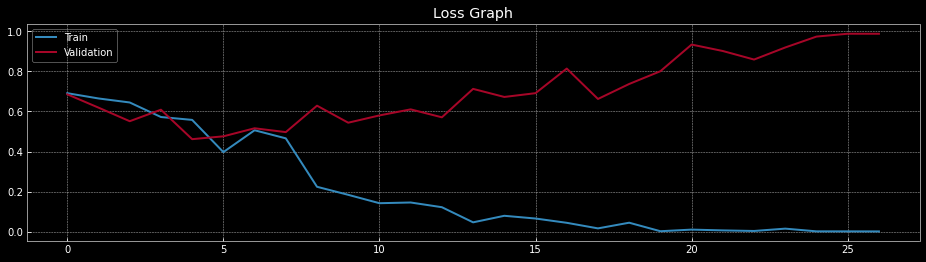

In [31]:
# Plotting loss graph
plt.plot(history_train_loss, label='Train')
plt.plot(history_val_loss, label='Validation')
plt.title('Loss Graph')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Validation Accuracy')

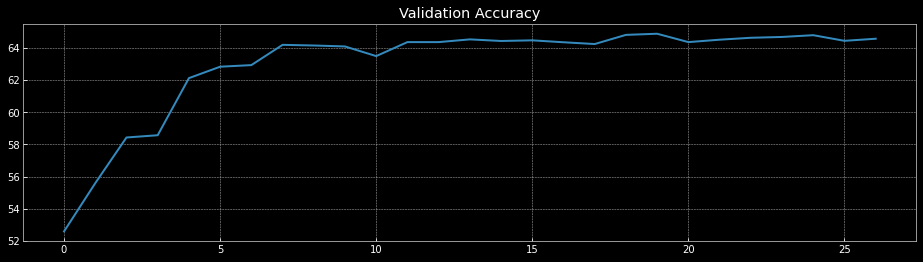

In [32]:
# Plotting validation accuracy graph
plt.plot(history_val_acc)
plt.title('Validation Accuracy')

In [43]:
weights = torch.Tensor().to(device)
for param_group in list(model.parameters()):
    weights = torch.cat((param_group.view(-1), weights))
    print(param_group.size())
    
# Toggle 0: No regularization
weights_nothing = weights.cpu().detach().numpy()

# Toggle 1: L1 norm on FC1
weights_L1 = weights.detach().numpy()

# Toggle 2: L2 norm
weights_L2 = weights.detach().numpy()

# Toggle 3: dropout
weights_dropout = weights.detach().numpy()

torch.Size([1002, 80])
torch.Size([32, 6400])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


(array([ 1435.,  1455.,  1477.,  1475.,  1631.,  1635.,  2037.,  5682.,
        25325., 75725., 75674., 25081.,  5674.,  2018.,  1606.,  1504.,
         1449.,  1340.,  1457.,  1398.]),
 array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
        -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45,  0.5 ], dtype=float32),
 <BarContainer object of 20 artists>)

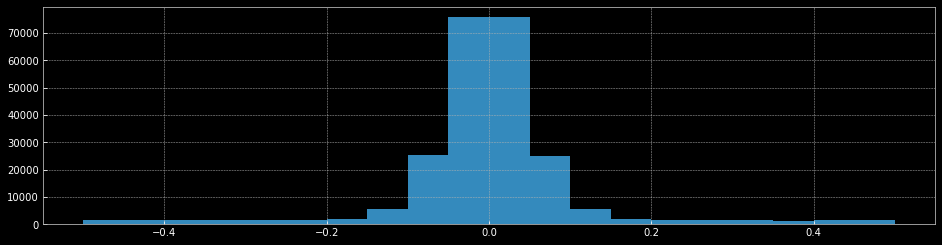

In [44]:
plt.hist(weights_L1.reshape(-1), range=(-.5, .5), bins=20)

(array([ 1435.,  1455.,  1477.,  1475.,  1631.,  1635.,  2037.,  5682.,
        25325., 75725., 75674., 25081.,  5674.,  2018.,  1606.,  1504.,
         1449.,  1340.,  1457.,  1398.]),
 array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
        -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45,  0.5 ], dtype=float32),
 <BarContainer object of 20 artists>)

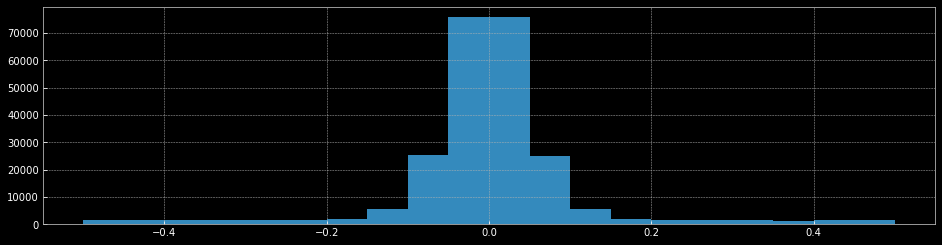

In [45]:
plt.hist(weights_nothing.reshape(-1), range=(-.5, .5), bins=20)

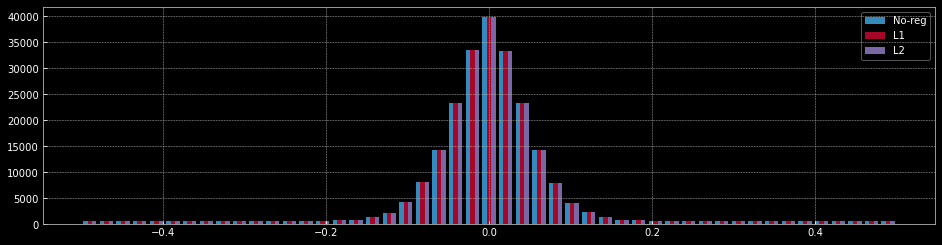

In [46]:
# Show weight distribution
plt.hist((
    weights_nothing.reshape(-1),
    weights_L1.reshape(-1),
    weights_L2.reshape(-1),
), 49, range=(-.5, .5), label=(
    'No-reg',
    'L1',
    'L2',
))
plt.legend();